In [1]:
library(MASS)

In [5]:
df <- Pima.tr

In [6]:
head(df)

npreg,glu,bp,skin,bmi,ped,age,type
5,86,68,28,30.2,0.364,24,No
7,195,70,33,25.1,0.163,55,Yes
5,77,82,41,35.8,0.156,35,No
0,165,76,43,47.9,0.259,26,No
0,107,60,25,26.4,0.133,23,No
5,97,76,27,35.6,0.378,52,Yes


In [13]:
library("DALEX")
library("randomForest")
library("ceterisParibus")
set.seed(59)

# set default theme
theme_set(theme_bw() + theme(text = element_text(size = 18)))

In [14]:
df <- df[sample(nrow(df)),]

In [18]:
left <- nrow(df) - 40
pina_test <- df[left:nrow(df),]
pina_train <- df[1:(left - 1),]

In [19]:
table(pina_test$type)


 No Yes 
 24  17 

In [20]:
table(pina_train$type)


 No Yes 
108  51 

In [25]:
pina_rf_model <- randomForest(type~., 
                        data = pina_train)


In [43]:
pred1 <- function(m, x)   predict(m, x, type = "prob")[,1]
pred2 <- function(m, x)   predict(m, x, type = "prob")[,2]

In [52]:
explainer_rf_no <- explain(pina_rf_model, data = pina_train[,1:7], 
                              y = pina_train$type == "no", 
                              predict_function = pred1, label = "no")
explainer_rf_yes <- explain(pina_rf_model, data = pina_train[,1:7], 
                              y = pina_train$type == "yes", 
                              predict_function = pred2, label = "yes")

In [55]:
cp_rf1 <- ceteris_paribus(explainer_rf_yes, pina_train[1:10,])
cp_rf2 <- ceteris_paribus(explainer_rf_no, pina_train[1:10,])

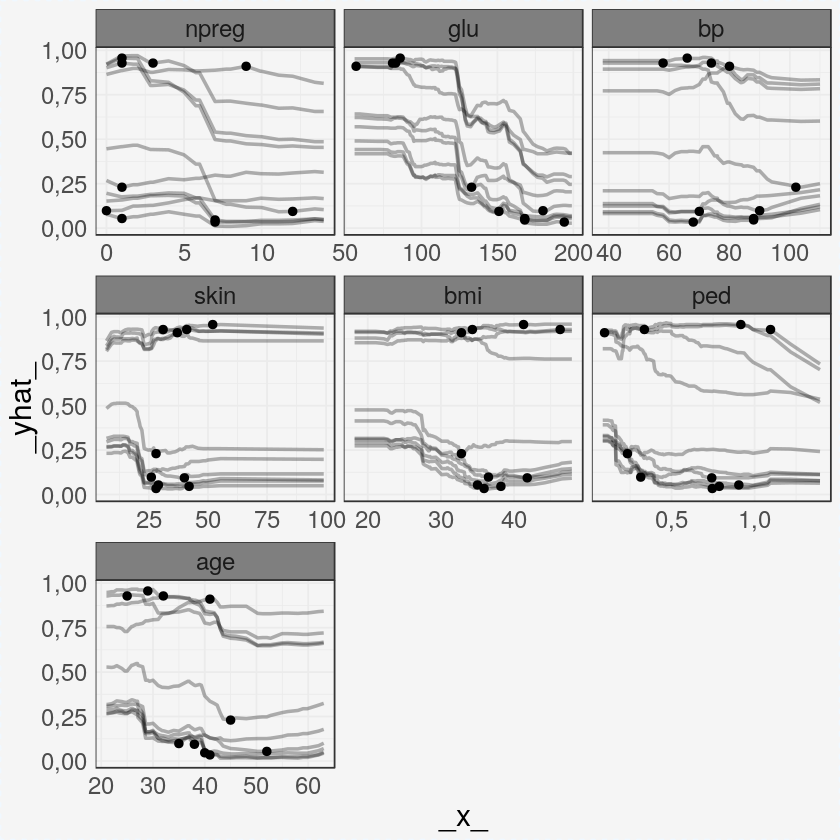

In [57]:
plot(cp_rf2)

In [70]:
person_A <- select_neighbours(pina_test, pina_test[2,], n = 20)

In [71]:
person_A

,npreg,glu,bp,skin,bmi,ped,age,type
186,0,138,60,35,"34,6","0,534",21,Yes
28,0,140,65,26,"42,6","0,431",24,Yes
33,0,121,66,30,"34,3","0,203",33,Yes
87,1,115,70,30,"34,6","0,529",32,Yes
193,1,128,48,45,"40,5","0,613",24,Yes
49,3,171,72,33,"33,3","0,199",24,Yes
160,3,158,76,36,"31,6","0,851",28,Yes
19,1,149,68,29,"29,3","0,349",42,Yes
167,0,151,90,46,"42,1","0,371",21,Yes
35,2,105,80,45,"33,7","0,711",29,Yes


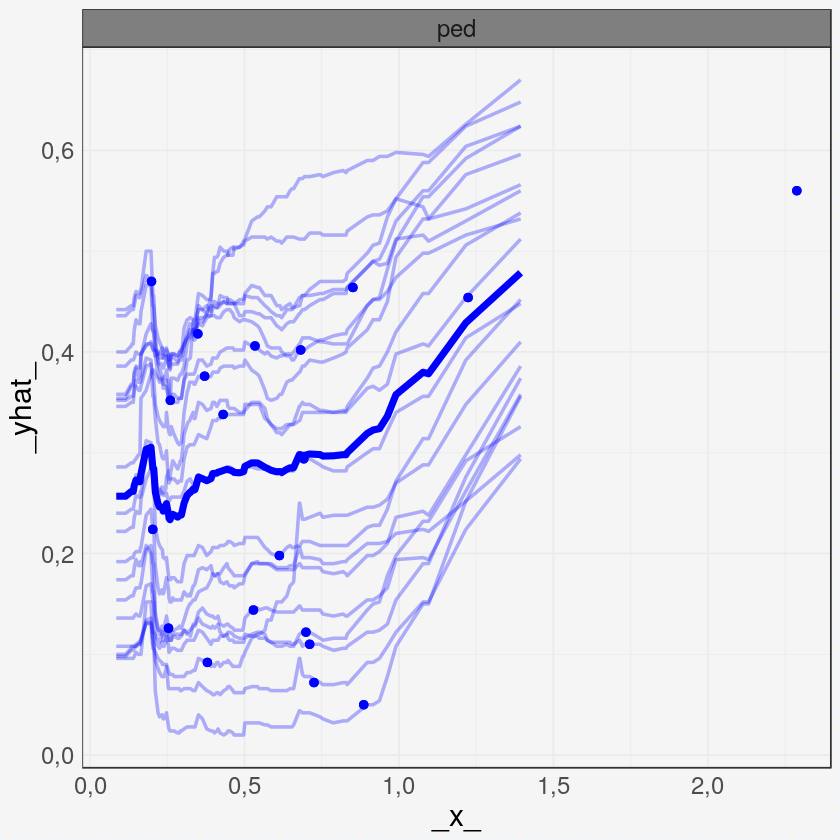

In [80]:
cp_rf_A <- ceteris_paribus(explainer_rf_yes, person_A)

plot(cp_rf_A, color="blue", show_profiles = TRUE, show_observations = TRUE, selected_variables=c("ped")) + 
      ceteris_paribus_layer(cp_rf_A, color="blue", show_observations=FALSE
            aggregate_profiles = mean, size = 2, alpha = 1, selected_variables = c("ped"))